### Affichage des classes

In [4]:
import os

# Chemin des datasets d'entraînement et de test
train_path = "PVF-10\\PVF_10_110x60\\train"
test_path = "PVF-10\\PVF_10_110x60\\test"

# Classes des datasets d'entraînement
classes = sorted(os.listdir(train_path))
print("Classes train :", *classes, sep="\n")

print("\nClasses test identiques ? => ", classes == sorted(os.listdir(test_path)))

Classes train :
01bottom dirt
02break
03Debris cover
04junction box heat
05hot cell
06shadow
07short circuit panel
08string short circuit
09substring open circuit
10healthy panel

Classes test identiques ? =>  True


### Affichage d'images

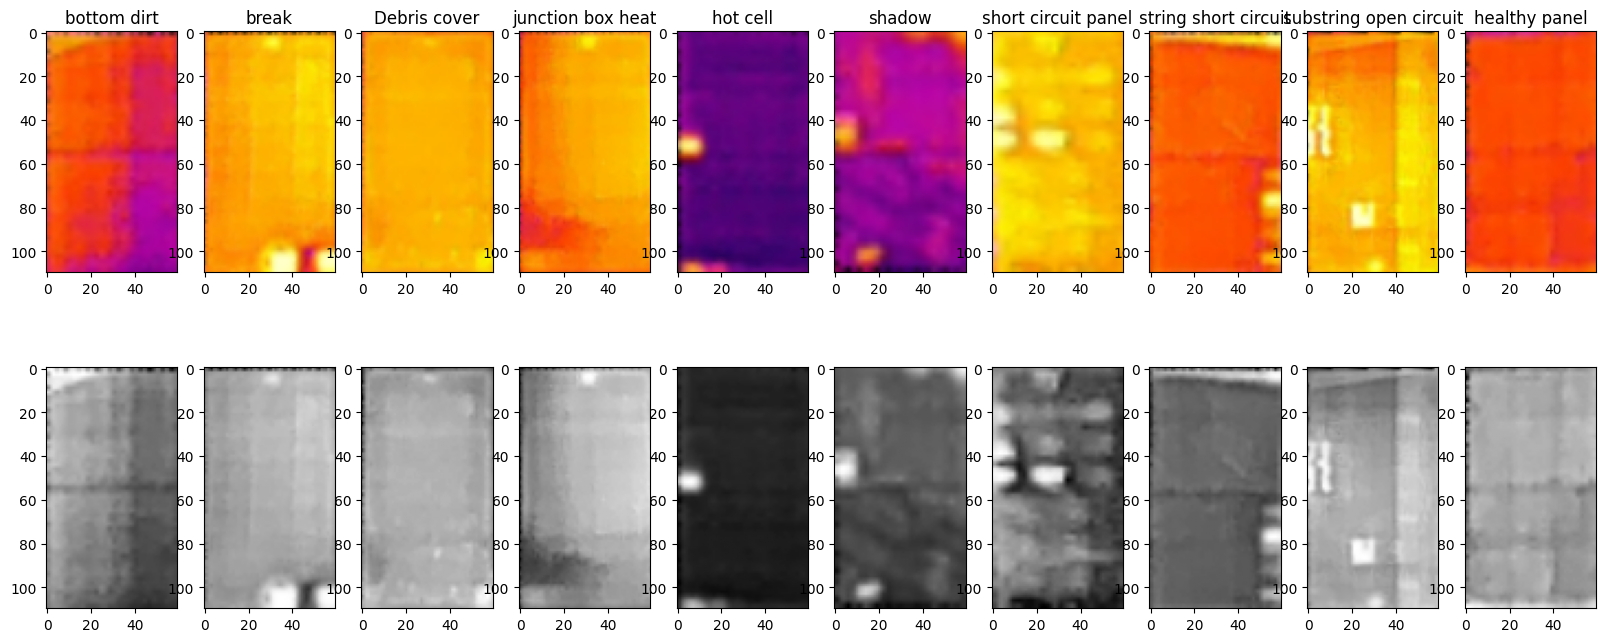

In [23]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Affichage d'une image par classe
nums_image = np.random.randint(50, size=len(classes))
fig, ax = plt.subplots(2, len(classes), figsize=(20, 8))
idx_ax= 0
for cls in classes:
    img_path = os.path.join(train_path, cls, os.listdir(os.path.join(train_path, cls))[nums_image[idx_ax]])
    img = cv2.imread(img_path)
    # Conversion BGR => RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[0,idx_ax].imshow(img_rgb)
    ax[0,idx_ax].set_title(cls[2:])
    # Conversion BGR => Niveau de gris
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ax[1,idx_ax].imshow(img_gray,cmap='gray')
    idx_ax+=1

plt.show()

### Chargement des datasets

In [25]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Transformation des images (redimensionnement, normalisation)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Certaines archis exigent 3 canaux
    transforms.Resize((224, 224)),  # Taille adaptée à ResNet
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5])
# ])

# Chargement / transformation des datasets d'entraînement et de test
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# Chargement par batch
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Entraînement ResNet18

In [26]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Utiliser CUDA si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger un modèle pré-entraîné (ex : ResNet18)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))  # Adapter au nombre de classes
model = model.to(device)

# Définir la fonction de coût et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement sur plusieurs époques
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Boucle d'entraînement
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


d:\Sources\PVF\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Sources\PVF\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.8363081357807298
Epoch 2/10, Loss: 0.46966286998572226
Epoch 3/10, Loss: 0.3964782279880741
Epoch 4/10, Loss: 0.3525521181335178
Epoch 5/10, Loss: 0.2910111550288864
Epoch 6/10, Loss: 0.28397108704040325
Epoch 7/10, Loss: 0.22319607534504768
Epoch 8/10, Loss: 0.21747792019402679
Epoch 9/10, Loss: 0.2005415194420309
Epoch 10/10, Loss: 0.15091310018272716


### Evaluation

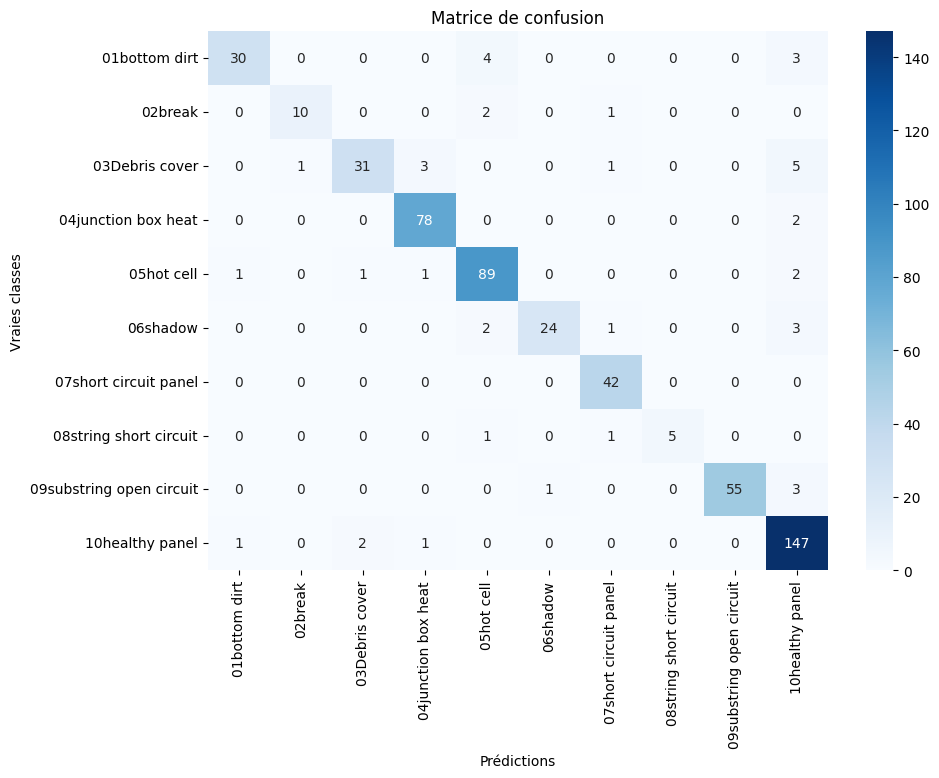

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Prédictions sur l'ensemble de test
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Matrice de confusion
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",xticklabels=classes, yticklabels=classes)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de confusion")
plt.show()

In [28]:
from sklearn.metrics import classification_report

# Générer le rapport de classification
class_report = classification_report(all_labels, all_preds, target_names=classes)

# Afficher le rapport
print("Rapport de classification :\n", class_report)

Rapport de classification :
                           precision    recall  f1-score   support

           01bottom dirt       0.94      0.81      0.87        37
                 02break       0.91      0.77      0.83        13
          03Debris cover       0.91      0.76      0.83        41
     04junction box heat       0.94      0.97      0.96        80
              05hot cell       0.91      0.95      0.93        94
                06shadow       0.96      0.80      0.87        30
   07short circuit panel       0.91      1.00      0.95        42
  08string short circuit       1.00      0.71      0.83         7
09substring open circuit       1.00      0.93      0.96        59
         10healthy panel       0.89      0.97      0.93       151

                accuracy                           0.92       554
               macro avg       0.94      0.87      0.90       554
            weighted avg       0.92      0.92      0.92       554

